In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, roc_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import seaborn as sns

In [2]:
train_df = pd.read_csv('fraudTrain.csv')
test_df = pd.read_csv('fraudTest.csv')

In [3]:
df = pd.concat([train_df, test_df], axis=0)

In [4]:
def preprocess_data(df):
    # Convert date to datetime
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    
    # Extract features from datetime
    df['hour'] = df['trans_date_trans_time'].dt.hour
    df['day'] = df['trans_date_trans_time'].dt.day
    df['month'] = df['trans_date_trans_time'].dt.month
    
    # One-hot encode categorical variables
    categorical_cols = ['category', 'gender']
    df = pd.get_dummies(df, columns=categorical_cols)
    
    # Drop unnecessary columns
    cols_to_drop = ['trans_date_trans_time', 'merchant', 'first', 'last', 'street', 'city', 'state', 'job', 'dob', 'trans_num', 'unix_time']
    df = df.drop(columns=cols_to_drop)
    
    return df

In [5]:
df_processed = preprocess_data(df)

In [6]:
X = df_processed.drop('is_fraud', axis=1)
y = df_processed['is_fraud']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

C:\Users\harsh\anaconda3\envs\deepfake_detector\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\harsh\anaconda3\envs\deepfake_detector\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\harsh\anaconda3\envs\deepfake_detector\lib\subprocess.py", line 493, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\harsh\anaconda3\envs\deepfake_detector\lib\subprocess.py", line 858, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\harsh\anaconda3\envs\deepfake_detector\lib\subprocess.py", line 1327, in _execute_

In [10]:
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_resampled, y_train_resampled)


LogisticRegression(max_iter=1000, random_state=42)

In [11]:
y_pred = lr_model.predict(X_test_scaled)
y_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]


In [12]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print(f"\nAUC-ROC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"Average Precision Score: {average_precision_score(y_test, y_pred_proba):.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.88      0.94    368549
           1       0.03      0.76      0.06      1930

    accuracy                           0.88    370479
   macro avg       0.52      0.82      0.50    370479
weighted avg       0.99      0.88      0.93    370479


Confusion Matrix:
[[324517  44032]
 [   454   1476]]

AUC-ROC Score: 0.9160
Average Precision Score: 0.1553


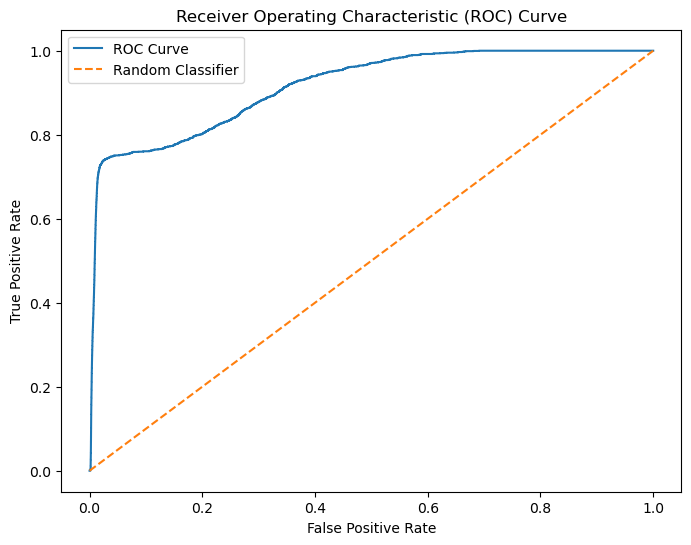

In [13]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

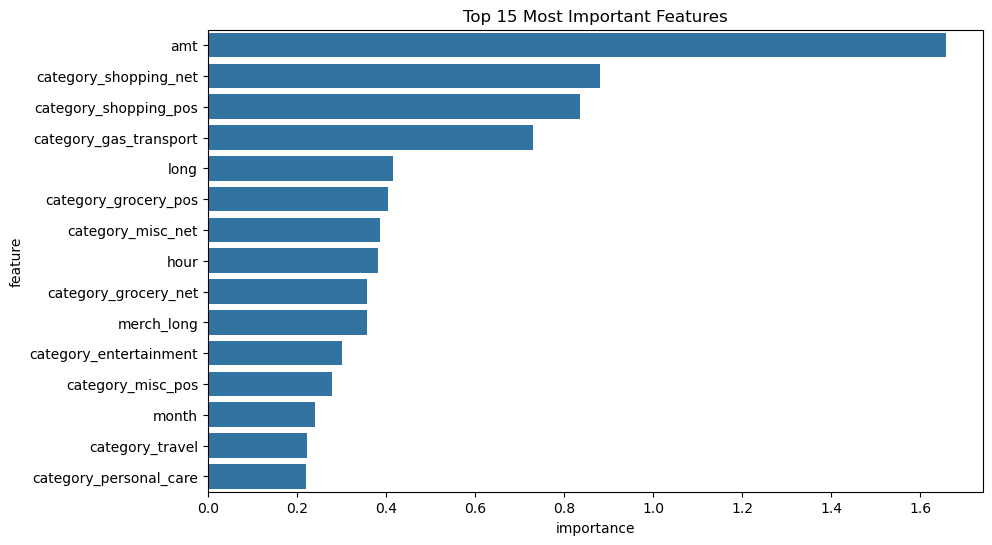

In [14]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': np.abs(lr_model.coef_[0])
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top 15 Most Important Features')
plt.show()

In [17]:
y_train_pred = lr_model.predict(X_train_resampled)
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)

# Calculate testing accuracy
y_test_pred = lr_model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

Training Accuracy: 0.8167
Testing Accuracy: 0.8799


In [18]:
y_train_pred = lr_model.predict(X_train_resampled)
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)

# Calculate testing accuracy
y_test_pred = lr_model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Continue with your other evaluation metrics...
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

# If you want to calculate AUC-ROC, make sure to use predict_proba for probability scores
y_test_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]
print(f"\nAUC-ROC Score: {roc_auc_score(y_test, y_test_pred_proba):.4f}")
print(f"Average Precision Score: {average_precision_score(y_test, y_test_pred_proba):.4f}")

Training Accuracy: 0.8167
Testing Accuracy: 0.8799

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.88      0.94    368549
           1       0.03      0.76      0.06      1930

    accuracy                           0.88    370479
   macro avg       0.52      0.82      0.50    370479
weighted avg       0.99      0.88      0.93    370479


Confusion Matrix:
[[324517  44032]
 [   454   1476]]

AUC-ROC Score: 0.9160
Average Precision Score: 0.1553
